# Data Cleaning and Preprocessing


Imports


In [141]:
import pandas as pd
import numpy as np
from fitter import Fitter, get_common_distributions
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import warnings
from datetime import datetime, timedelta
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

pd.set_option("future.no_silent_downcasting", True)

Read the orders dataset into a pandas dataframe


In [2]:
orders_df = pd.read_csv("../Data/orders_data_competition.csv")

In [3]:
orders_df.head()

,Order ID,Account ID,Market Key,Security ID,Order Type,Order Time,Order Via,Is Completed,Is Canceled,Expire Date,Execution Status,quantity,Price,Sector Name,Executed Quantity,Quantity
0,0,2312,Egypt,0,Buy,2024-01-10 10:16:10.000,Online,1,0,2024-01-10 00:00:00.000,Executed,100,66.30,Real Estate,100,100
1,1,1196,Egypt,0,Sell,2024-01-10 10:16:11.000,Online,1,0,2024-01-10 00:00:00.000,Executed,200,66.00,Real Estate,200,200
2,2,1759,Egypt,0,Buy,2024-01-10 10:16:12.000,Online,0,1,2024-01-10 00:00:00.000,Not Executed,200,65.00,Real Estate,0,200
3,3,4476,Egypt,1,Sell,2024-01-10 10:16:16.000,Online,0,1,2024-01-10 00:00:00.000,Not Executed,820,75.20,Financials,0,820
4,4,838,Egypt,2,Sell,2024-01-10 10:16:18.000,Online,0,1,2024-01-10 00:00:00.000,Not Executed,500,10.68,Materials,0,500


Read the clients dataset into a pandas dataframe


In [4]:
clients_df = pd.read_csv("../Data/clients_data_competition.csv")

In [5]:
clients_df.head()

,Client ID,Account ID,Gender,Risk Rate,Company Name,Is Closed,Is Dormant,Is Profile Suspended,Is Client Suspended,Client Type Name,OpenDate,BirthDate
0,0,0,Male,Low,HSB,0,0.0,0,0,Individuals,2/16/2014,1990-07-27
1,1,1,Female,Low,HSB,0,-1.0,1,0,Individuals,2/16/2014,1963-10-22
2,2,2,Male,Low,HSB,0,0.0,0,0,Individuals,2/17/2014,1971-05-14
3,3,3,Male,Low,HSB,0,0.0,0,0,Individuals,2/17/2014,1953-01-14
4,4,4,Male,Low,HSB,0,0.0,0,0,Individuals,2/17/2014,1976-06-09


## Account Level Dataset


### Orders Data


**_We created another dataframe "agg_orders" which represents the aggregate orders of each account_**


Drop the rows with null values


In [6]:
orders_df.dropna(inplace=True)

In [7]:
orders_df = orders_df[orders_df["Order Via"] == "Online"]

In [8]:
orders_df.drop(columns=["Order Via", "Security ID"], inplace=True)

In [9]:
account_ids_to_remove = clients_df[
    (clients_df["Client Type Name"] != "Individuals")
    | (clients_df["Company Name"] != "HSB")
]["Account ID"].unique()

# Remove the accounts from the accounts dataframe where Client Type Name is not 'individuals'
clients_df = clients_df[~clients_df["Account ID"].isin(account_ids_to_remove)]

# Remove the orders of these accounts from the orders dataframe
orders_df = orders_df[~orders_df["Account ID"].isin(account_ids_to_remove)]

In [10]:
clients_df.drop(columns=["Client Type Name", "Company Name"], inplace=True)

In [11]:
len(clients_df["Account ID"].unique())

11323

In [12]:
len(orders_df["Account ID"].unique())

6715

In [13]:
# Check if there are any accounts in the orders dataframe that are not in the accounts dataframe
accounts_in_orders_not_in_accounts = orders_df[
    ~orders_df["Account ID"].isin(clients_df["Account ID"])
]
if accounts_in_orders_not_in_accounts.empty:
    print(
        "There are no accounts in the orders dataframe that are not in the accounts dataframe."
    )
else:
    print(
        "There are accounts in the orders dataframe that are not in the accounts dataframe."
    )

# Check if there are any accounts in the accounts dataframe that are not in the orders dataframe
accounts_in_accounts_not_in_orders = clients_df[
    ~clients_df["Account ID"].isin(orders_df["Account ID"])
]
if accounts_in_accounts_not_in_orders.empty:
    print(
        "There are no accounts in the accounts dataframe that are not in the orders dataframe."
    )
else:
    print(
        "There are accounts in the accounts dataframe that are not in the orders dataframe."
    )

There are no accounts in the orders dataframe that are not in the accounts dataframe.
There are accounts in the accounts dataframe that are not in the orders dataframe.


In [14]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1833491 entries, 0 to 1987940
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Order ID           int64  
 1   Account ID         int64  
 2   Market Key         object 
 3   Order Type         object 
 4   Order Time         object 
 5   Is Completed       int64  
 6   Is Canceled        int64  
 7   Expire Date        object 
 8   Execution Status   object 
 9   quantity           int64  
 10  Price              float64
 11  Sector Name        object 
 12  Executed Quantity  int64  
 13  Quantity           int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 209.8+ MB


Initialize a new Dataframe to store the aggregate orders per account


In [15]:
agg_orders = pd.DataFrame()

Add an AccountID column to the aggregate orders df


In [16]:
agg_orders["AccountID"] = clients_df["Account ID"].unique()

Compute and add the number of orders for each account


In [17]:
# Add a NumOfOrders column that has the number of orders for each account
agg_orders["NumOfOrders"] = orders_df.groupby("Account ID").size()

# Set the number of orders for the accounts that didn't place any order to 0
agg_orders["NumOfOrders"] = agg_orders["NumOfOrders"].fillna(0)

# Convert the type to int
agg_orders["NumOfOrders"] = agg_orders["NumOfOrders"].astype(int)

Compute and add the last order date for each account


In [18]:
# Convert the 'order_date' column to datetime
orders_df["Order Time"] = pd.to_datetime(orders_df["Order Time"])

# Create a new dataframe with the last order date for each account
agg_orders["LastOrder"] = orders_df.groupby("Account ID")["Order Time"].max()

# Convert the LastOrder column to datetime
agg_orders["LastOrder"] = pd.to_datetime(agg_orders["LastOrder"], format="%d-%m-%Y")

Compute and add the first order date for each account


In [19]:
# Create a new dataframe with the last order date for each account
agg_orders["FirstOrder"] = orders_df.groupby("Account ID")["Order Time"].min()

# Convert the LastOrder column to datetime
agg_orders["FirstOrder"] = pd.to_datetime(agg_orders["FirstOrder"], format="%d-%m-%Y")

Compute and add the number of completed orders for each account


In [20]:
# Add a NumOfCompleted column that has the number of completed orders for each account
agg_orders["NumOfCompleted"] = orders_df.groupby("Account ID")["Is Completed"].sum()

# Set the number of completed orders for the accounts that didn't place any order to 0
agg_orders["NumOfCompleted"] = agg_orders["NumOfCompleted"].fillna(0)

# # Convert the type to int
agg_orders["NumOfCompleted"] = agg_orders["NumOfCompleted"].astype(int)

Compute and add the number of canceled for each account


In [21]:
# Add a NumOfCanceled column that has the number of completed orders for each account
agg_orders["NumOfCanceled"] = orders_df.groupby("Account ID")["Is Canceled"].sum()

# Set the number of completed orders for the accounts that didn't place any order to 0
agg_orders["NumOfCanceled"] = agg_orders["NumOfCanceled"].fillna(0)

# # Convert the type to int
agg_orders["NumOfCanceled"] = agg_orders["NumOfCanceled"].astype(int)

Compute and add the average price of orders for each account


In [22]:
# Add a AvgPrice column that has the number of completed orders for each account
agg_orders["AvgPrice"] = (
    orders_df.groupby("Account ID")["Price"].sum()
    / orders_df.groupby("Account ID").size()
)

# Set the number of completed orders for the accounts that didn't place any order to 0
agg_orders["AvgPrice"] = agg_orders["AvgPrice"].fillna(0.0)

Compute and add the total quantity of orders for each account


In [23]:
# Add a TotalQuantity column that has the number of completed orders for each account
agg_orders["TotalQuantity"] = orders_df.groupby("Account ID")["Quantity"].sum()

# Set the number of completed orders for the accounts that didn't place any order to 0
agg_orders["TotalQuantity"] = agg_orders["TotalQuantity"].fillna(0)

# # Convert the type to int
agg_orders["TotalQuantity"] = agg_orders["TotalQuantity"].astype(int)

Define a function to convert a categorical feature to its TFIDF dataframe and concatenate it with the aggregate orders dataframe


In [24]:
def getMostFrequent(column_name: str):
    temp = pd.DataFrame(data=agg_orders.iloc[:, 0])
    col_name = f"Most_Frequent_{column_name}"
    temp[col_name] = orders_df.groupby("Account ID")[column_name].apply(
        lambda x: x.mode().iloc[0]
    )
    return pd.concat([agg_orders, temp.iloc[:, 1:]], axis=1)

Compute and add the Frequency Encoding of the Order Type column


In [25]:
agg_orders = getMostFrequent("Order Type")

Compute and add the Frequency Encoding of the Execution Status column


In [26]:
agg_orders = getMostFrequent("Execution Status")

Compute and add the Frequency Encoding of the Sector Name column


In [27]:
agg_orders = getMostFrequent("Sector Name")

Display the head of the agg_orders dataframe


In [28]:
agg_orders.head()

,AccountID,NumOfOrders,LastOrder,FirstOrder,NumOfCompleted,NumOfCanceled,AvgPrice,TotalQuantity,Most_Frequent_Order Type,Most_Frequent_Execution Status,Most_Frequent_Sector Name
0,0,0,NaT,NaT,0,0,0.000000,0,NaN,NaN,NaN
1,1,0,NaT,NaT,0,0,0.000000,0,NaN,NaN,NaN
2,2,21,2024-02-28 11:06:33,2022-01-04 12:06:31,17,2,7.652667,137395,Buy,Executed,Industries
3,3,87,2024-03-10 12:32:34,2023-01-17 12:02:35,64,11,71.908161,908478,Sell,Executed,Financials
4,4,30,2024-02-26 12:47:33,2022-01-11 11:05:32,8,10,2.846267,594953,Sell,Not Executed,Financials


Display the info of the agg_orders dataframe


In [29]:
agg_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11323 entries, 0 to 11322
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   AccountID                       11323 non-null  int64         
 1   NumOfOrders                     11323 non-null  int64         
 2   LastOrder                       5512 non-null   datetime64[ns]
 3   FirstOrder                      5512 non-null   datetime64[ns]
 4   NumOfCompleted                  11323 non-null  int64         
 5   NumOfCanceled                   11323 non-null  int64         
 6   AvgPrice                        11323 non-null  float64       
 7   TotalQuantity                   11323 non-null  int64         
 8   Most_Frequent_Order Type        5512 non-null   object        
 9   Most_Frequent_Execution Status  5512 non-null   object        
 10  Most_Frequent_Sector Name       5512 non-null   object        
dtypes:

### Clients Data


Drop the rows with null values


In [30]:
clients_df.dropna(inplace=True)

In [31]:
clients_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 11323 entries, 0 to 13521
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Client ID             11323 non-null  int64  
 1   Account ID            11323 non-null  int64  
 2   Gender                11323 non-null  object 
 3   Risk Rate             11323 non-null  object 
 4   Is Closed             11323 non-null  int64  
 5   Is Dormant            11323 non-null  float64
 6   Is Profile Suspended  11323 non-null  int64  
 7   Is Client Suspended   11323 non-null  int64  
 8   OpenDate              11323 non-null  object 
 9   BirthDate             11323 non-null  object 
dtypes: float64(1), int64(5), object(4)
memory usage: 973.1+ KB


Drop the suspended clients


In [32]:
clients_df = clients_df[clients_df["Is Client Suspended"] == 0]

In [33]:
clients_df.drop(columns="Is Client Suspended", inplace=True)

Convert the OpenDate column to DateTime object


In [34]:
# Convert the OpenDate column to datetime
clients_df["OpenDate"] = pd.to_datetime(clients_df["OpenDate"], format="%m/%d/%Y")

Convert the BirthDate column to DateTime object, and calculate the age of the client


In [35]:
# Convert the BirthDate column to datetime
clients_df["BirthDate"] = pd.to_datetime(clients_df["BirthDate"], format="%Y-%m-%d")

In [36]:
def calculate_age(birth_date):
    # Assuming birth_date is a datetime object
    today = datetime.today()
    return (
        today.year
        - birth_date.year
        - ((today.month, today.day) < (birth_date.month, birth_date.day))
    )

In [37]:
clients_df["Age"] = clients_df["BirthDate"].apply(calculate_age)

Remove all whitespaces in the column names


In [38]:
clients_df.rename(columns=lambda x: x.replace(" ", ""), inplace=True)

Display the head of the clients dataframe


In [39]:
clients_df.head()

,ClientID,AccountID,Gender,RiskRate,IsClosed,IsDormant,IsProfileSuspended,OpenDate,BirthDate,Age
0,0,0,Male,Low,0,0.0,0,2014-02-16,1990-07-27,33
1,1,1,Female,Low,0,-1.0,1,2014-02-16,1963-10-22,60
2,2,2,Male,Low,0,0.0,0,2014-02-17,1971-05-14,53
3,3,3,Male,Low,0,0.0,0,2014-02-17,1953-01-14,71
4,4,4,Male,Low,0,0.0,0,2014-02-17,1976-06-09,48


Display the info of the clients dataframe


In [40]:
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11222 entries, 0 to 13521
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ClientID            11222 non-null  int64         
 1   AccountID           11222 non-null  int64         
 2   Gender              11222 non-null  object        
 3   RiskRate            11222 non-null  object        
 4   IsClosed            11222 non-null  int64         
 5   IsDormant           11222 non-null  float64       
 6   IsProfileSuspended  11222 non-null  int64         
 7   OpenDate            11222 non-null  datetime64[ns]
 8   BirthDate           11222 non-null  datetime64[ns]
 9   Age                 11222 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(5), object(2)
memory usage: 964.4+ KB


### Merging


**_We will inner join the agg_orders and clients_df dataframes on the AccountID column_**


Perform the merging between both dataframes


In [41]:
df_account_level = pd.merge(clients_df, agg_orders, on="AccountID", how="inner")

In [42]:
# Get the current date
now = datetime.now()

In [43]:
order_rates_start = []
order_rates_end = []
quantity_rates_start = []
quantity_rates_end = []
avg_quantity_per_order_start = []
avg_quantity_per_order_end = []

In [44]:
for i, account in df_account_level.iterrows():
    midpointDate = account["OpenDate"] + (now - account["OpenDate"]) / 2
    openDate = account["OpenDate"]

    days_open_midpoint = (midpointDate - openDate).days
    days_midpoint_now = (now - midpointDate).days

    filtered_date_df = orders_df[
        (orders_df["Order Time"] >= openDate)
        & (orders_df["Order Time"] < midpointDate)
        & (orders_df["Account ID"] == account["AccountID"])
    ]

    filtered_df_2 = orders_df[
        (orders_df["Order Time"] >= midpointDate)
        & (orders_df["Order Time"] < now)
        & (orders_df["Account ID"] == account["AccountID"])
    ]

    num_of_orders_start = len(filtered_date_df)
    num_of_orders_end = len(filtered_df_2)

    quantity_ordered_start = filtered_date_df["Quantity"].sum()
    quantity_ordered_end = filtered_df_2["Quantity"].sum()

    avg_quantity_start = filtered_date_df["Quantity"].mean()
    avg_quantity_end = filtered_df_2["Quantity"].mean()

    order_rates_start.append(num_of_orders_start / days_open_midpoint)
    order_rates_end.append(num_of_orders_end / days_midpoint_now)

    quantity_rates_start.append(quantity_ordered_start / days_open_midpoint)
    quantity_rates_end.append(quantity_ordered_end / days_midpoint_now)

    avg_quantity_per_order_start.append(avg_quantity_start)
    avg_quantity_per_order_end.append(avg_quantity_end)

In [45]:
df_account_level["OrderRate_Start"] = pd.Series(order_rates_start)
df_account_level["OrderRate_End"] = pd.Series(order_rates_end)
df_account_level["QuantityOrderedRate_Start"] = pd.Series(quantity_rates_start)
df_account_level["QuantityOrderedRate_End"] = pd.Series(quantity_rates_end)
df_account_level["AvgQuantityPerOrder_Start"] = pd.Series(avg_quantity_per_order_start)
df_account_level["AvgQuantityPerOrder_End"] = pd.Series(avg_quantity_per_order_end)

In [46]:
df_account_level["AvgQuantityPerOrder_Start"] = df_account_level[
    "AvgQuantityPerOrder_Start"
].fillna(0)
df_account_level["AvgQuantityPerOrder_End"] = df_account_level[
    "AvgQuantityPerOrder_End"
].fillna(0)

Display the head of the dataframe


In [47]:
df_account_level.rename(columns=lambda x: x.replace(" ", ""), inplace=True)

In [48]:
df_account_level.head()

,ClientID,AccountID,Gender,RiskRate,IsClosed,IsDormant,IsProfileSuspended,OpenDate,BirthDate,Age,...,TotalQuantity,Most_Frequent_OrderType,Most_Frequent_ExecutionStatus,Most_Frequent_SectorName,OrderRate_Start,OrderRate_End,QuantityOrderedRate_Start,QuantityOrderedRate_End,AvgQuantityPerOrder_Start,AvgQuantityPerOrder_End
0,0,0,Male,Low,0,0.0,0,2014-02-16,1990-07-27,33,...,0,NaN,NaN,NaN,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,1,1,Female,Low,0,-1.0,1,2014-02-16,1963-10-22,60,...,0,NaN,NaN,NaN,0.0,0.000000,0.0,0.000000,0.0,0.000000
2,2,2,Male,Low,0,0.0,0,2014-02-17,1971-05-14,53,...,137395,Buy,Executed,Industries,0.0,0.011041,0.0,72.237119,0.0,6542.619048
3,3,3,Male,Low,0,0.0,0,2014-02-17,1953-01-14,71,...,908478,Sell,Executed,Financials,0.0,0.045741,0.0,477.643533,0.0,10442.275862
4,4,4,Male,Low,0,0.0,0,2014-02-17,1976-06-09,48,...,594953,Sell,Not Executed,Financials,0.0,0.015773,0.0,312.803891,0.0,19831.766667


Display the info of the dataframe


In [49]:
df_account_level.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11222 entries, 0 to 11221
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ClientID                       11222 non-null  int64         
 1   AccountID                      11222 non-null  int64         
 2   Gender                         11222 non-null  object        
 3   RiskRate                       11222 non-null  object        
 4   IsClosed                       11222 non-null  int64         
 5   IsDormant                      11222 non-null  float64       
 6   IsProfileSuspended             11222 non-null  int64         
 7   OpenDate                       11222 non-null  datetime64[ns]
 8   BirthDate                      11222 non-null  datetime64[ns]
 9   Age                            11222 non-null  int64         
 10  NumOfOrders                    11222 non-null  int64         
 11  LastOrder      

In [50]:
len(df_account_level["ClientID"].unique())

8790

## Client Level Dataset


In [51]:
df = pd.DataFrame()

In [52]:
# Create a new DataFrame with ClientID and corresponding account count
df = pd.DataFrame(
    {
        "ClientID": df_account_level.groupby("ClientID")["AccountID"].nunique().index,
    }
)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   ClientID  8790 non-null   int64
dtypes: int64(1)
memory usage: 68.8 KB


In [54]:
df["Gender"] = (df_account_level.groupby("ClientID")["Gender"].first().reset_index())[
    "Gender"
]
df["Age"] = (df_account_level.groupby("ClientID")["Age"].first().reset_index())["Age"]

df["RiskRate"] = (
    df_account_level.groupby("ClientID")["RiskRate"].first().reset_index()
)["RiskRate"]

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ClientID  8790 non-null   int64 
 1   Gender    8790 non-null   object
 2   Age       8790 non-null   int64 
 3   RiskRate  8790 non-null   object
dtypes: int64(2), object(2)
memory usage: 274.8+ KB


In [56]:
df["IsMale"] = df.apply(lambda row: (1 if row["Gender"] == "Male" else 0), axis=1)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ClientID  8790 non-null   int64 
 1   Gender    8790 non-null   object
 2   Age       8790 non-null   int64 
 3   RiskRate  8790 non-null   object
 4   IsMale    8790 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 343.5+ KB


In [58]:
df["NumOfAccounts"] = df_account_level.groupby("ClientID").size().values

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ClientID       8790 non-null   int64 
 1   Gender         8790 non-null   object
 2   Age            8790 non-null   int64 
 3   RiskRate       8790 non-null   object
 4   IsMale         8790 non-null   int64 
 5   NumOfAccounts  8790 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 412.2+ KB


In [60]:
df["NumOfClosedAccounts"] = (
    df_account_level.groupby("ClientID")["IsClosed"].sum().values
)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ClientID             8790 non-null   int64 
 1   Gender               8790 non-null   object
 2   Age                  8790 non-null   int64 
 3   RiskRate             8790 non-null   object
 4   IsMale               8790 non-null   int64 
 5   NumOfAccounts        8790 non-null   int64 
 6   NumOfClosedAccounts  8790 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 480.8+ KB


In [62]:
df["NumOfSuspendedAccounts"] = (
    df_account_level.groupby("ClientID")["IsProfileSuspended"].sum().values
)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ClientID                8790 non-null   int64 
 1   Gender                  8790 non-null   object
 2   Age                     8790 non-null   int64 
 3   RiskRate                8790 non-null   object
 4   IsMale                  8790 non-null   int64 
 5   NumOfAccounts           8790 non-null   int64 
 6   NumOfClosedAccounts     8790 non-null   int64 
 7   NumOfSuspendedAccounts  8790 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 549.5+ KB


In [64]:
df["NumOfOrders"] = df_account_level.groupby("ClientID")["NumOfOrders"].sum().values

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ClientID                8790 non-null   int64 
 1   Gender                  8790 non-null   object
 2   Age                     8790 non-null   int64 
 3   RiskRate                8790 non-null   object
 4   IsMale                  8790 non-null   int64 
 5   NumOfAccounts           8790 non-null   int64 
 6   NumOfClosedAccounts     8790 non-null   int64 
 7   NumOfSuspendedAccounts  8790 non-null   int64 
 8   NumOfOrders             8790 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 618.2+ KB


In [66]:
df = df[df["NumOfOrders"] > 0].reset_index()

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4826 entries, 0 to 4825
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   4826 non-null   int64 
 1   ClientID                4826 non-null   int64 
 2   Gender                  4826 non-null   object
 3   Age                     4826 non-null   int64 
 4   RiskRate                4826 non-null   object
 5   IsMale                  4826 non-null   int64 
 6   NumOfAccounts           4826 non-null   int64 
 7   NumOfClosedAccounts     4826 non-null   int64 
 8   NumOfSuspendedAccounts  4826 non-null   int64 
 9   NumOfOrders             4826 non-null   int64 
dtypes: int64(8), object(2)
memory usage: 377.2+ KB


In [68]:
valid_client_ids = set(df["ClientID"])
df_account_level = df_account_level[df_account_level["ClientID"].isin(valid_client_ids)]

In [69]:
df["NumOfCompletedOrders"] = (
    df_account_level.groupby("ClientID")["NumOfCompleted"].sum().values
)

In [70]:
df["NumOfCanceledOrders"] = (
    df_account_level.groupby("ClientID")["NumOfCanceled"].sum().values
)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4826 entries, 0 to 4825
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   4826 non-null   int64 
 1   ClientID                4826 non-null   int64 
 2   Gender                  4826 non-null   object
 3   Age                     4826 non-null   int64 
 4   RiskRate                4826 non-null   object
 5   IsMale                  4826 non-null   int64 
 6   NumOfAccounts           4826 non-null   int64 
 7   NumOfClosedAccounts     4826 non-null   int64 
 8   NumOfSuspendedAccounts  4826 non-null   int64 
 9   NumOfOrders             4826 non-null   int64 
 10  NumOfCompletedOrders    4826 non-null   int64 
 11  NumOfCanceledOrders     4826 non-null   int64 
dtypes: int64(10), object(2)
memory usage: 452.6+ KB


In [72]:
df["CompletedOrdersRatio"] = df.apply(
    lambda row: (
        1
        if row["NumOfOrders"] == 0
        else row["NumOfCompletedOrders"] / row["NumOfOrders"]
    ),
    axis=1,
)

In [73]:
df["CanceledOrdersRatio"] = df.apply(
    lambda row: (
        1
        if row["NumOfOrders"] == 0
        else row["NumOfCanceledOrders"] / row["NumOfOrders"]
    ),
    axis=1,
)

In [74]:
df["TotalQuantity"] = df_account_level.groupby("ClientID")["TotalQuantity"].sum().values

In [75]:
df["AvgPrice"] = (
    df_account_level.groupby("ClientID")["AvgPrice"].sum()
    / df_account_level.groupby("ClientID").size()
).values

In [76]:
grouped_df = (
    df_account_level.groupby("ClientID")["Most_Frequent_OrderType"]
    .apply(lambda x: x.mode().iloc[0])
    .reset_index()
)
df = pd.concat([df, grouped_df.iloc[:, 1:]], axis=1)

In [77]:
grouped_df = (
    df_account_level.groupby("ClientID")["Most_Frequent_ExecutionStatus"]
    .apply(lambda x: x.mode().iloc[0])
    .reset_index()
)

df = pd.concat([df, grouped_df.iloc[:, 1:]], axis=1)

In [78]:
grouped_df = (
    df_account_level.groupby("ClientID")["Most_Frequent_SectorName"]
    .apply(lambda x: x.mode().iloc[0])
    .reset_index()
)
df = pd.concat([df, grouped_df.iloc[:, 1:]], axis=1)

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4826 entries, 0 to 4825
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          4826 non-null   int64  
 1   ClientID                       4826 non-null   int64  
 2   Gender                         4826 non-null   object 
 3   Age                            4826 non-null   int64  
 4   RiskRate                       4826 non-null   object 
 5   IsMale                         4826 non-null   int64  
 6   NumOfAccounts                  4826 non-null   int64  
 7   NumOfClosedAccounts            4826 non-null   int64  
 8   NumOfSuspendedAccounts         4826 non-null   int64  
 9   NumOfOrders                    4826 non-null   int64  
 10  NumOfCompletedOrders           4826 non-null   int64  
 11  NumOfCanceledOrders            4826 non-null   int64  
 12  CompletedOrdersRatio           4826 non-null   f

In [80]:
df["LastOrderDateAcrossAccounts"] = (
    df_account_level.groupby("ClientID")["LastOrder"].max().values
)

df["LastOrderDateAcrossAccounts"] = pd.to_datetime(
    df["LastOrderDateAcrossAccounts"].dt.date
)

Define a function so that we can compute if the account is dormant or not.

If the account has not placed any order, we set the Is Dormant value to -1, so that we can isolate the accounts who have not placed any orders.


In [81]:
def check_dormant(date):
    one_year_before_now = datetime.now() - timedelta(days=183)

    if date < one_year_before_now:
        return 1
    else:
        return 0

Recompute the Is Dormant column


In [82]:
df["IsDormant"] = df["LastOrderDateAcrossAccounts"].apply(check_dormant)

In [83]:
df["AvgOrderRate_Start"] = (
    df_account_level.groupby("ClientID")["OrderRate_Start"].mean().values
)

In [84]:
df["AvgOrderRate_End"] = (
    df_account_level.groupby("ClientID")["OrderRate_End"].mean().values
)

In [85]:
df["AvgOrderRate_Difference"] = df["AvgOrderRate_End"] - df["AvgOrderRate_Start"]

In [86]:
df["AvgQuantityOrderedRate_Start"] = (
    df_account_level.groupby("ClientID")["QuantityOrderedRate_Start"].mean().values
)

In [87]:
df["AvgQuantityOrderedRate_End"] = (
    df_account_level.groupby("ClientID")["QuantityOrderedRate_End"].mean().values
)

In [88]:
df["AvgQuantityOrderedRate_Difference"] = (
    df["AvgQuantityOrderedRate_End"] - df["AvgQuantityOrderedRate_Start"]
)

In [89]:
df["AvgQuantityPerAccount_Start"] = (
    df_account_level.groupby("ClientID")["AvgQuantityPerOrder_Start"].mean().values
)

In [90]:
df["AvgQuantityPerAccount_End"] = (
    df_account_level.groupby("ClientID")["AvgQuantityPerOrder_End"].mean().values
)

In [91]:
df["AvgQuantityPerAccount_Difference"] = (
    df["AvgQuantityPerAccount_End"] - df["AvgQuantityPerAccount_Start"]
)

In [92]:
df["ClosedAccountsRatio"] = df["NumOfClosedAccounts"] / df["NumOfAccounts"]

In [93]:
df["SuspendedAccountsRatio"] = df["NumOfSuspendedAccounts"] / df["NumOfAccounts"]

In [94]:
df["ActiveAccountsRatio"] = df.apply(
    lambda row: (
        0
        if (row["NumOfSuspendedAccounts"] + row["NumOfClosedAccounts"])
        >= row["NumOfAccounts"]
        else 1 - (row["ClosedAccountsRatio"] + row["SuspendedAccountsRatio"])
    ),
    axis=1,
)

In [95]:
df.head()

,index,ClientID,Gender,Age,RiskRate,IsMale,NumOfAccounts,NumOfClosedAccounts,NumOfSuspendedAccounts,NumOfOrders,...,AvgOrderRate_Difference,AvgQuantityOrderedRate_Start,AvgQuantityOrderedRate_End,AvgQuantityOrderedRate_Difference,AvgQuantityPerAccount_Start,AvgQuantityPerAccount_End,AvgQuantityPerAccount_Difference,ClosedAccountsRatio,SuspendedAccountsRatio,ActiveAccountsRatio
0,2,2,Male,53,Low,1,1,0,0,21,...,0.011041,0.000000,72.237119,72.237119,0.00,6542.619048,6542.619048,0.0,0.0,1.0
1,3,3,Male,71,Low,1,1,0,0,87,...,0.045741,0.000000,477.643533,477.643533,0.00,10442.275862,10442.275862,0.0,0.0,1.0
2,4,4,Male,48,Low,1,2,0,0,30,...,0.008936,0.000000,165.813278,165.813278,0.00,14400.383333,14400.383333,0.0,0.0,1.0
3,7,7,Male,70,Not Assigned,1,1,0,0,28,...,-0.318182,332.420455,0.000000,-332.420455,1044.75,0.000000,-1044.750000,0.0,0.0,1.0
4,8,8,Male,38,Medium,1,3,0,0,65,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,1.0


In [96]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4826 entries, 0 to 4825
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   index                              4826 non-null   int64         
 1   ClientID                           4826 non-null   int64         
 2   Gender                             4826 non-null   object        
 3   Age                                4826 non-null   int64         
 4   RiskRate                           4826 non-null   object        
 5   IsMale                             4826 non-null   int64         
 6   NumOfAccounts                      4826 non-null   int64         
 7   NumOfClosedAccounts                4826 non-null   int64         
 8   NumOfSuspendedAccounts             4826 non-null   int64         
 9   NumOfOrders                        4826 non-null   int64         
 10  NumOfCompletedOrders               4

## Binning


Columns to be binned:

-   AvgOrderRate_Difference
-   AvgQuantityOrderedRate_Difference
-   CompletedOrdersRatio
-   CanceledOrdersRatio
-   ActiveAccountsRatio


### AvgOrderRate_Difference


In [97]:
print(f"Difference is < 0: {len(df[df["AvgOrderRate_Difference"] < 0])}")
print(f"Difference is 0: {len(df[df["AvgOrderRate_Difference"] == 0])}")
print(f"Difference > 0: {len(df[df["AvgOrderRate_Difference"] > 0])}")

Difference is < 0: 1052
Difference is 0: 1525
Difference > 0: 2249


<Axes: xlabel='AvgOrderRate_Difference', ylabel='Count'>

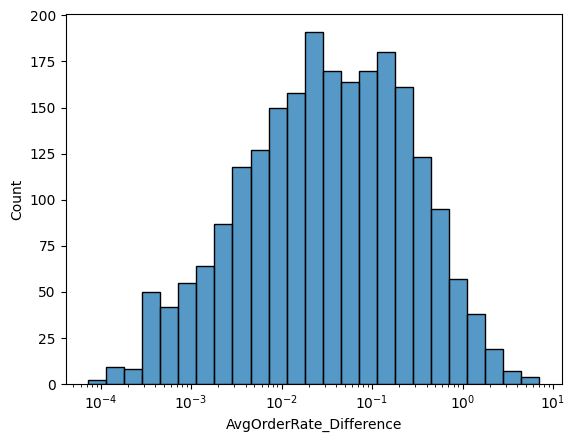

In [98]:
sns.histplot(data=df, x="AvgOrderRate_Difference", log_scale=True)

In [99]:
def bin_AvgOrderRate_Difference(value):
    if value < 0:
        return "Decreased"
    elif value == 0:
        return "Constant"
    else:
        return "Increased"

In [100]:
df["AvgOrderRate_Difference"] = df["AvgOrderRate_Difference"].apply(
    bin_AvgOrderRate_Difference
)

### AvgQuantityOrderedRate_Difference


In [101]:
print(f"Difference is < 0: {len(df[df["AvgQuantityOrderedRate_Difference"] < 0])}")
print(f"Difference is 0: {len(df[df["AvgQuantityOrderedRate_Difference"] == 0])}")
print(f"Difference > 0: {len(df[df["AvgQuantityOrderedRate_Difference"] > 0])}")

Difference is < 0: 1033
Difference is 0: 1520
Difference > 0: 2273


<Axes: xlabel='AvgQuantityOrderedRate_Difference', ylabel='Count'>

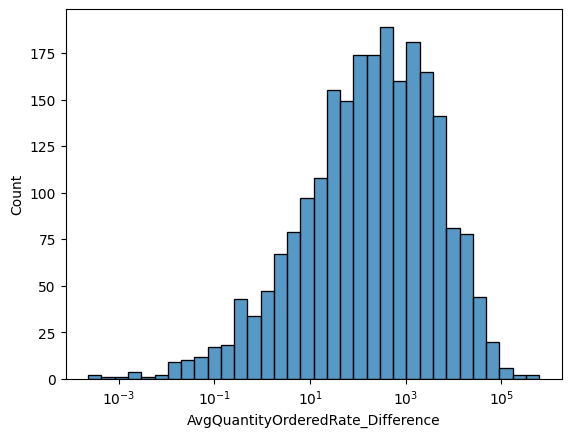

In [102]:
sns.histplot(data=df, x="AvgQuantityOrderedRate_Difference", log_scale=True)

In [103]:
def bin_AvgQuantityOrderedRate_Difference(value):
    if value < 0:
        return "Decreased"
    elif value == 0:
        return "Constant"
    else:
        return "Increased"

In [104]:
df["AvgQuantityOrderedRate_Difference"] = df["AvgQuantityOrderedRate_Difference"].apply(
    bin_AvgQuantityOrderedRate_Difference
)

### CompletedOrdersRatio


<Axes: xlabel='CompletedOrdersRatio', ylabel='Count'>

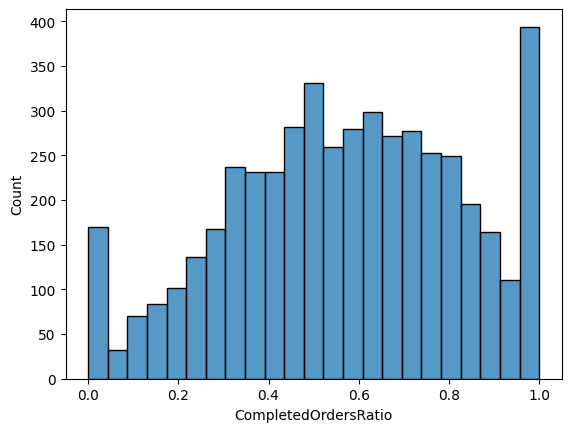

In [105]:
sns.histplot(data=df, x="CompletedOrdersRatio", log_scale=False)

In [106]:
def bin_CompletedOrdersRatio(value):
    if value == 0:
        return "None"
    elif value > 0 and value < 0.5:
        return "Less than half"
    elif value >= 0.5 and value < 1:
        return "More than half"
    else:
        return "All"

In [107]:
df["CompletedOrdersRatio"] = df["CompletedOrdersRatio"].apply(bin_CompletedOrdersRatio)

### CanceledOrdersRatio


<Axes: xlabel='CanceledOrdersRatio', ylabel='Count'>

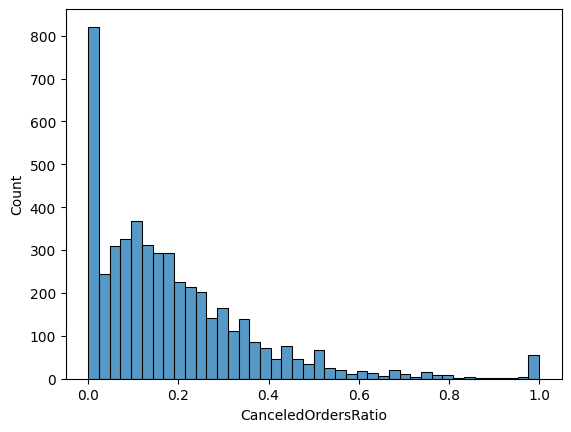

In [108]:
sns.histplot(data=df, x="CanceledOrdersRatio", log_scale=False)

In [109]:
def bin_CanceledOrdersRatio(value):
    if value == 0:
        return "None"
    elif 0 < value <= 0.1:
        return "Little"
    elif 0.1 < value <= 0.3:
        return "Moderate"
    elif 0.3 < value < 1:
        return "Most"
    elif value == 1:
        return "All"

In [110]:
df["CanceledOrdersRatio"] = df["CanceledOrdersRatio"].apply(bin_CanceledOrdersRatio)

## Defining The Label


**_We defined our label to be a combination of multiple features_**


Create the label


In [111]:
df["Churned"] = (df["IsDormant"] == 1) | (df["ActiveAccountsRatio"] < 0.5)

df = df.replace({True: 1, False: 0})

df["Churned"] = df["Churned"].astype(int)

In [112]:
print(len(df[df["Churned"] == 1]) / len(df))
print(len(df[df["Churned"] == 0]) / len(df))

0.467882304185661
0.532117695814339


Drop the columns used for creating the label to remove bias, also drop the unnecessary columns


In [113]:
df.drop(
    columns=[
        "IsDormant",
        "ActiveAccountsRatio",
        "SuspendedAccountsRatio",
        "TotalQuantity",
        "LastOrderDateAcrossAccounts",
        "AvgOrderRate_Start",
        "AvgOrderRate_End",
        "AvgQuantityOrderedRate_Start",
        "AvgQuantityOrderedRate_End",
        "AvgQuantityPerAccount_Start",
        "AvgQuantityPerAccount_End",
        "AvgQuantityPerAccount_Difference",
        "NumOfClosedAccounts",
        "NumOfAccounts",
        "NumOfSuspendedAccounts",
        "NumOfOrders",
        "NumOfCompletedOrders",
        "NumOfCanceledOrders",
        "ClosedAccountsRatio",
        "Gender",
        "index",
    ],
    inplace=True,
)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4826 entries, 0 to 4825
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ClientID                           4826 non-null   int64  
 1   Age                                4826 non-null   int64  
 2   RiskRate                           4826 non-null   object 
 3   IsMale                             4826 non-null   int64  
 4   CompletedOrdersRatio               4826 non-null   object 
 5   CanceledOrdersRatio                4826 non-null   object 
 6   AvgPrice                           4826 non-null   float64
 7   Most_Frequent_OrderType            4826 non-null   object 
 8   Most_Frequent_ExecutionStatus      4826 non-null   object 
 9   Most_Frequent_SectorName           4826 non-null   object 
 10  AvgOrderRate_Difference            4826 non-null   object 
 11  AvgQuantityOrderedRate_Difference  4826 non-null   objec

In [115]:
df.to_csv("../Data/visualization_data.csv", index=False)

## OHE


Split the data


In [116]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

The columns to be one-hot encoded


In [117]:
columns = [
    "RiskRate",
    "AvgOrderRate_Difference",
    "AvgQuantityOrderedRate_Difference",
    "CompletedOrdersRatio",
    "CanceledOrdersRatio",
    "Most_Frequent_OrderType",
    "Most_Frequent_ExecutionStatus",
    "Most_Frequent_SectorName",
]

OHE these columns


In [118]:
def one_hot_encode(categorical_columns, train_df, test_df):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    encoder.fit(train_df[categorical_columns])

    train_encoded = encoder.transform(train_df[categorical_columns])
    test_encoded = encoder.transform(test_df[categorical_columns])

    train_encoded_df = pd.DataFrame(
        train_encoded, columns=encoder.get_feature_names_out(categorical_columns)
    )
    test_encoded_df = pd.DataFrame(
        test_encoded, columns=encoder.get_feature_names_out(categorical_columns)
    )

    train_encoded_df = train_encoded_df.astype("int8")
    test_encoded_df = test_encoded_df.astype("int8")

    train_df = train_df.drop(categorical_columns, axis=1).reset_index(drop=True)
    test_df = test_df.drop(categorical_columns, axis=1).reset_index(drop=True)

    train_df = pd.concat([train_df, train_encoded_df], axis=1)
    test_df = pd.concat([test_df, test_encoded_df], axis=1)

    return train_df, test_df, encoder

In [119]:
train_df, test_df, encoder = one_hot_encode(columns, train_df, test_df)

Remove all whitespaces in the column names


In [120]:
train_df.rename(columns=lambda x: x.replace(" ", ""), inplace=True)
test_df.rename(columns=lambda x: x.replace(" ", ""), inplace=True)

In [121]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3860 entries, 0 to 3859
Data columns (total 48 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   ClientID                                            3860 non-null   int64  
 1   Age                                                 3860 non-null   int64  
 2   IsMale                                              3860 non-null   int64  
 3   AvgPrice                                            3860 non-null   float64
 4   Churned                                             3860 non-null   int64  
 5   RiskRate_High                                       3860 non-null   int8   
 6   RiskRate_Low                                        3860 non-null   int8   
 7   RiskRate_Medium                                     3860 non-null   int8   
 8   RiskRate_NotAssigned                                3860 non-null   int8   
 9

In [122]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 48 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   ClientID                                            966 non-null    int64  
 1   Age                                                 966 non-null    int64  
 2   IsMale                                              966 non-null    int64  
 3   AvgPrice                                            966 non-null    float64
 4   Churned                                             966 non-null    int64  
 5   RiskRate_High                                       966 non-null    int8   
 6   RiskRate_Low                                        966 non-null    int8   
 7   RiskRate_Medium                                     966 non-null    int8   
 8   RiskRate_NotAssigned                                966 non-null    int8   
 9  

## Normalization


The columns to be normalized


In [123]:
columns = [
    "Age",
    "AvgPrice",
]

Define a function to normalize the data based on a distribution


In [124]:
def get_normalized_data(data, dist):
    if dist == "uniform":
        scaler = MinMaxScaler().fit(data)
    elif dist == "norm":
        scaler = StandardScaler().fit(data)
    elif dist == "cauchy":
        ranked = stats.rankdata(data, method="average")
        percentiles = 100.0 * (ranked - 1) / (len(data) - 1)
        quantiles = np.percentile(data, percentiles)
        return quantiles
    else:
        return np.log(np.abs(data.flatten()) + 1)
    return scaler

Define a function to get the best distribution that fits the data


In [125]:
def get_best_distribution(columns, df):
    columns_distributions_dict = {column: "" for column in columns}

    for column in columns:
        print("###### " + column + " ######")
        data = df[column].values

        f = Fitter(
            data,
            distributions=get_common_distributions(),
        )
        f.fit()
        f.summary(plot=False)
        dist = f.get_best(method="sumsquare_error")
        best_dist = list(dist.keys())[0]

        columns_distributions_dict[column] = str(best_dist)
        print(column)
        print(f"Best Distribution: {best_dist}")
        print()

    return columns_distributions_dict

Define a function to normalize the data based on its best distribution


In [126]:
def normalize(columns, train_df, test_df):
    columns_distributions_dict = get_best_distribution(columns, train_df)
    scalers = {}

    for column in columns_distributions_dict.keys():
        train_data = np.array(train_df[column]).reshape(-1, 1)
        test_data = np.array(test_df[column]).reshape(-1, 1)
        dist = columns_distributions_dict[column]
        scaler = get_normalized_data(train_data, dist)

        if dist in ["uniform", "norm"]:
            train_df[column] = scaler.transform(train_data)
            test_df[column] = scaler.transform(np.array(test_df[column]).reshape(-1, 1))
            scalers[column] = scaler
        elif dist == "cauchy":
            train_df[column] = scaler
            ranked = stats.rankdata(test_df[column], method="average")
            percentiles = 100.0 * (ranked - 1) / (len(test_df[column]) - 1)
            test_df[column] = np.percentile(test_df[column], percentiles)
        else:
            train_df[column] = scaler
            test_df[column] = np.log(np.abs(test_data.flatten()) + 1)

    return columns_distributions_dict, scalers

Normalize the data


In [127]:
columns_distributions_dict, scalers = normalize(columns, train_df, test_df)

###### Age ######


2024-07-18 18:17:49.467 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.020807)
2024-07-18 18:17:49.474 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.029318)
2024-07-18 18:17:49.490 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.01965)
2024-07-18 18:17:49.502 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.020308)
2024-07-18 18:17:49.511 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.018736)
2024-07-18 18:17:49.538 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.024037)
2024-07-18 18:17:49.548 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.020807)
2024-07-18 18:17:49.631 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted

Age
Best Distribution: powerlaw

###### AvgPrice ######


2024-07-18 18:17:49.895 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.004112)
2024-07-18 18:17:49.904 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=6.5e-05)
2024-07-18 18:17:49.919 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=0.001311)


AvgPrice
Best Distribution: expon



In [128]:
print(columns_distributions_dict)

{'Age': 'powerlaw', 'AvgPrice': 'expon'}


## Saving


Make the Churned column to be the last column


In [129]:
cols = list(train_df.columns)
cols.append(cols.pop(cols.index("Churned")))
train_df = train_df[cols]

cols = list(test_df.columns)
cols.append(cols.pop(cols.index("Churned")))
test_df = test_df[cols]

In [130]:
train_df = train_df.iloc[:, 1:]
test_df = test_df.iloc[:, 1:]

In [131]:
columns = [
    "Churned",
    "IsMale",
]

In [132]:
for col in columns:
    train_df[col] = train_df[col].astype("int8")
    test_df[col] = test_df[col].astype("int8")

Display the head of the dataframe


In [133]:
train_df.head()

,Age,IsMale,AvgPrice,RiskRate_High,RiskRate_Low,RiskRate_Medium,RiskRate_NotAssigned,AvgOrderRate_Difference_Constant,AvgOrderRate_Difference_Decreased,AvgOrderRate_Difference_Increased,...,Most_Frequent_SectorName_InformationTechnology,Most_Frequent_SectorName_Materials,Most_Frequent_SectorName_Others,Most_Frequent_SectorName_REALESTATE,Most_Frequent_SectorName_RealEstate,Most_Frequent_SectorName_SERVICES,Most_Frequent_SectorName_TelecommunicationServices,Most_Frequent_SectorName_Telecommunications,Most_Frequent_SectorName_Tourism,Churned
0,4.143135,1,2.160640,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3.583519,1,2.534777,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,3.828641,1,3.096990,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,4.094345,1,0.439076,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
4,3.526361,1,1.459124,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [134]:
test_df.head()

,Age,IsMale,AvgPrice,RiskRate_High,RiskRate_Low,RiskRate_Medium,RiskRate_NotAssigned,AvgOrderRate_Difference_Constant,AvgOrderRate_Difference_Decreased,AvgOrderRate_Difference_Increased,...,Most_Frequent_SectorName_InformationTechnology,Most_Frequent_SectorName_Materials,Most_Frequent_SectorName_Others,Most_Frequent_SectorName_REALESTATE,Most_Frequent_SectorName_RealEstate,Most_Frequent_SectorName_SERVICES,Most_Frequent_SectorName_TelecommunicationServices,Most_Frequent_SectorName_Telecommunications,Most_Frequent_SectorName_Tourism,Churned
0,4.094345,0,3.348502,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,3.828641,1,3.818886,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,4.317488,0,1.840632,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4.356709,0,1.993102,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.970292,1,1.097923,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


Display the info of the dataframe


In [135]:
train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3860 entries, 0 to 3859
Data columns (total 47 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Age                                                 3860 non-null   float64
 1   IsMale                                              3860 non-null   int8   
 2   AvgPrice                                            3860 non-null   float64
 3   RiskRate_High                                       3860 non-null   int8   
 4   RiskRate_Low                                        3860 non-null   int8   
 5   RiskRate_Medium                                     3860 non-null   int8   
 6   RiskRate_NotAssigned                                3860 non-null   int8   
 7   AvgOrderRate_Difference_Constant                    3860 non-null   int8   
 8   AvgOrderRate_Difference_Decreased                   3860 non-null   int8   
 9

In [136]:
test_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 47 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Age                                                 966 non-null    float64
 1   IsMale                                              966 non-null    int8   
 2   AvgPrice                                            966 non-null    float64
 3   RiskRate_High                                       966 non-null    int8   
 4   RiskRate_Low                                        966 non-null    int8   
 5   RiskRate_Medium                                     966 non-null    int8   
 6   RiskRate_NotAssigned                                966 non-null    int8   
 7   AvgOrderRate_Difference_Constant                    966 non-null    int8   
 8   AvgOrderRate_Difference_Decreased                   966 non-null    int8   
 9  

Save the traing and testing data into 2 CSVs


In [137]:
train_df.to_csv("../Data/train_set.csv", index=False)

In [138]:
test_df.to_csv("../Data/test_set.csv", index=False)